In [1]:
import torch
import numpy as np
import torch.nn as nn
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

In [2]:
# Для хождения по гугл диску
os.chdir('drive/MyDrive/DataSets/')

In [2]:
# Скачиваем датасет
! pip install -q kaggle # Предпологается что kaggle.json уже в этой папке
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ml-intensive-yandex-academy-autumn-2024

100%|█████████████████████████████████████▉| 7.90G/7.90G [06:01<00:00, 19.8MB/s]
100%|██████████████████████████████████████| 7.90G/7.90G [06:01<00:00, 23.5MB/s]


In [3]:
# Распаковка и удаление зипа
! unzip ml-intensive-yandex-academy-autumn-2024.zip && rm ml-intensive-yandex-academy-autumn-2024.zip


Archive:  ml-intensive-yandex-academy-autumn-2024.zip
  inflating: human_poses_data/activity_categories.csv  
  inflating: human_poses_data/img_test/0.jpg  
  inflating: human_poses_data/img_test/100.jpg  
  inflating: human_poses_data/img_test/10000.jpg  
  inflating: human_poses_data/img_test/10003.jpg  
  inflating: human_poses_data/img_test/10004.jpg  
  inflating: human_poses_data/img_test/10007.jpg  
  inflating: human_poses_data/img_test/10008.jpg  
  inflating: human_poses_data/img_test/10009.jpg  
  inflating: human_poses_data/img_test/10015.jpg  
  inflating: human_poses_data/img_test/10016.jpg  
  inflating: human_poses_data/img_test/10017.jpg  
  inflating: human_poses_data/img_test/1002.jpg  
  inflating: human_poses_data/img_test/10022.jpg  
  inflating: human_poses_data/img_test/10025.jpg  
  inflating: human_poses_data/img_test/1003.jpg  
  inflating: human_poses_data/img_test/10030.jpg  
  inflating: human_poses_data/img_test/10032.jpg  
  inflating: human_poses_data/i

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Преобразую в 227 на 227, тк Alexnet нужны такие
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
#Добавляю генератор, для сида
generator = torch.Generator().manual_seed(22)

In [7]:
dataset = HumanPoseDataset(
    img_dir='../data/img_train',
    csv_file='../data/train_answers.csv',
    transform=transform
)
train_dataset, test_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))], generator)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)


In [8]:
# test_dataset = HumanPoseDataset(
#     img_dir='/content/drive/MyDrive/DataSets/human_poses_data/img_test',
#     csv_file='/content/drive/MyDrive/DataSets/human_poses_data/train_answers.csv',
#     transform=transform
# )

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)


In [9]:
train_dataset[2]

(tensor([[[-1.5528, -1.6384, -1.6213,  ..., -0.6109, -1.2788, -0.5596],
          [-1.5528, -1.6042, -1.5699,  ..., -0.5424, -1.2617, -0.5767],
          [-1.5699, -1.5014, -1.5014,  ..., -0.3883, -1.2617, -0.5938],
          ...,
          [ 0.3309,  0.3481,  0.3481,  ..., -1.8097, -1.7583, -1.5014],
          [ 0.3309,  0.4337,  0.4337,  ..., -1.7583, -1.7240, -1.6213],
          [ 0.4508,  0.4851,  0.4508,  ..., -1.6727, -1.7412, -1.7240]],
 
         [[-1.4580, -1.5280, -1.5280,  ..., -0.8627, -1.4755, -0.8978],
          [-1.4580, -1.4930, -1.4755,  ..., -0.7577, -1.4580, -0.8978],
          [-1.4755, -1.4055, -1.3880,  ..., -0.5826, -1.4405, -0.8978],
          ...,
          [ 0.6779,  0.7129,  0.7829,  ..., -1.0028, -0.7577, -0.3901],
          [ 0.6954,  0.8004,  0.8354,  ..., -0.9678, -0.8978, -0.6352],
          [ 0.8179,  0.8354,  0.8354,  ..., -0.8978, -0.9853, -0.7927]],
 
         [[-1.2293, -1.3339, -1.3339,  ..., -0.7413, -1.3861, -1.1073],
          [-1.2293, -1.2990,

In [28]:
# Загружаем категории
categories = pd.read_csv('/content/drive/MyDrive/DataSets/human_poses_data/activity_categories.csv')

# Создаем маппинг id -> category
id_to_category = dict(zip(categories['id'], categories['category']))


In [10]:
import matplotlib.pyplot as plt
import os
from torchvision.utils import make_grid

# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label = dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)


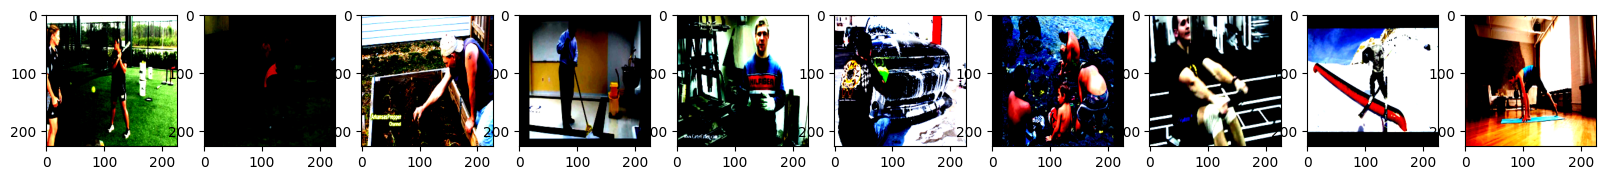

In [ ]:
show_images_with_labels(train_dataset, id_to_category)

Откуда черпал инфу по архитектуре модели                      
https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/

https://en.wikipedia.org/wiki/AlexNet

https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
    

In [11]:
class model(nn.Module):
    def __init__(self, num_classes):
        super(model, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
summary(model(19), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [13]:
model = model(19).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [14]:
!pip install pytorch-ignite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 18.6 MB/s eta 0:00:00


In [30]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Precision, Recall, Fbeta
from ignite.engine import Events
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler
trainer = create_supervised_trainer(model, optimizer, criterion, device)

In [31]:
# metrics = {
#     "precision": Precision(),
#     "recall": Recall(),
#     "loss": Loss(criterion),
#     "f1-score": (Precision() * Recall() * 2 / (Precision() + Recall())).mean()
# }

metrics = {
    "precision": Precision(average=True),  # Макро-среднее по умолчанию
    "recall": Recall(average=True),
    "loss": Loss(criterion),
    "f1-score": (Precision(average=True) * Recall(average=True) * 2 / (Precision(average=True) + Recall(average=True)))
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

train_metrics_history = []
test_metrics_history = []

In [32]:
#Я оставил вывод метрик в консоль, для удобного отслеживания эпох
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

save_dir = "checkpoints/"
def save_model(engine):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = f"{save_dir}/modelAlex_epoch_{engine.state.epoch}__iter_{engine.state.iteration}.pth"
    # torch.save(model.state_dict(), checkpoint_path)
    torch.save({
        "epoch": engine.state.epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, checkpoint_path)

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), log_iter_loss)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), save_model)

def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    test_evaluator.run(test_loader)

# trainer.add_event_handler(Events.ITERATION_COMPLETED(every=100), compute_epoch_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

# Функция для логирования и сохранения результатов метрик
def log_epoch_results(engine, label, metrics_history):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    out = {}
    for m, v in engine.state.metrics.items():
        out[m] = v
    metrics_history.append(out)
    print(f"{label} Res:", result)

# Привязываем обработчики к событиям
train_evaluator.add_event_handler(
    Events.EPOCH_COMPLETED,
    log_epoch_results,
    label="Train",
    metrics_history=train_metrics_history
)
test_evaluator.add_event_handler(
    Events.EPOCH_COMPLETED,
    log_epoch_results,
    label="Test",
    metrics_history=test_metrics_history
)


scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

test_evaluator.add_event_handler(Events.COMPLETED, scheduler)
test_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [ ]:

# Функция для отображения графиков метрик и лоса
# Усреднил значения precision и recall, чтобы были не шумные графики
def show_grafics(train_metrics_history, test_metrics_history):
    f1_score_train = [epoch['f1-score'] for epoch in train_metrics_history]
    f1_score_test = [epoch['f1-score'] for epoch in test_metrics_history]
    loss_train = [epoch['loss'] for epoch in train_metrics_history]
    loss_test = [epoch['loss'] for epoch in test_metrics_history]

    plt.figure(figsize=(16, 12))

    plt.subplot(2, 3, 1)
    plt.title('Loss Train')
    plt.plot(np.arange(len(loss_train)), loss_train)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 3, 2)
    plt.title('Loss Test')
    plt.plot(np.arange(len(loss_test)), loss_test)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 3, 3)
    plt.title('f1 Train')
    plt.plot(np.arange(len(f1_score_train)), f1_score_train)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 3, 4)
    plt.title('f1 Test')
    plt.plot(np.arange(len(f1_score_test)), f1_score_test)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [33]:
device

device(type='cpu')

In [34]:
trainer.run(train_loader, 11)

Epoch[1] - Iter[100]: loss = 2.9426939487457275
Epoch[1] - Iter[200]: loss = 2.933253049850464
Epoch[1] - Iter[300]: loss = 2.9342195987701416
Train Res: precision = 0.010668179883671443, recall = 0.05263157894736842, loss = 2.9221336618373766, f1-score = 0.017740451532237137
Test Res: precision = 0.010892226524273496, recall = 0.05263157894736842, loss = 2.9220230238227565, f1-score = 0.01804914160820672
Optimizer learning rate = 0.001


ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: 